## Import Packages

In [2]:
import subprocess, sys
import numpy as np
import pandas as pd
import ssl
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import heapq
import itertools
import random
import copy
import pickle
from statistics import mean , stdev
from sklearn import datasets 
from sklearn.metrics import confusion_matrix 
from sklearn.neighbors import KNeighborsClassifier
from pprint import pprint
from sklearn.model_selection import train_test_split
import plotly.plotly as py
import scipy.cluster.hierarchy as hierarchy
from scipy.linalg import svd
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from sklearn import metrics 
from sklearn.cluster import AgglomerativeClustering

## Data Preprocessing

In [3]:
def data_preprocessing():
    
    
    df = pd.read_csv("intrusion_detection.csv")

#     print(df.info(verbose=True))
    
    df["xAttack"] = df.apply(convert_string_to_float, axis=1)
    
    X = df.values[:, :-1] 
    y = df.values[:, -1]

    X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size = 0.3,random_state = 0) 

    return X_train, X_validation, y_train, y_validation

## Feature Scaling

In [4]:
def feature_scaling(train_data):
    
    no_of_columns = train_data.shape[1]
    
    global sd_mean_list
    
    sd_mean_list = []
    
    for index in range(no_of_columns):

        sd_val = np.std(train_data[:,index])
        mean_val = np.mean(train_data[:,index])
        train_data[:,index] = (train_data[:,index] - mean_val)/(sd_val)
        
        sd_mean_list.append([sd_val,mean_val])
        
    return train_data

## Scaling Test Data

In [5]:
def scale_test_data(X_test):
    
    global sd_mean_list
    
    for test_row in X_test:
        
        for index in range(len(test_row)):

            mean = sd_mean_list[index][1]
            sd = sd_mean_list[index][0]

            test_row[index] = (test_row[index] - mean)/sd

    return X_test

## Convert string type label column to float

In [6]:
def convert_string_to_float(test_row):
    
    if test_row[-1] == "normal":
        return 0
    elif test_row[-1] == "dos":
        return  1
    elif test_row[-1] == "u2r":
        return  2
    elif test_row[-1] == "r2l":
        return  3
    elif test_row[-1] == "probe":
        return  4

# AutoEncoder

In [7]:
class neural_layer:
    
    def __init__(self,weight,bias):
        
        self.weight = weight
        self.bias = bias
        self.activations = None
        self.delta = None

In [8]:
class Neural_Network:
    
    def __init__(self, layer_sizes = None, activation_function = None,mode = "training",bottleneck_layer_index = None):
        
        if mode == "training": 
            
            self.layer_sizes = layer_sizes
            self.activation_function = activation_function
            self.bottleneck_layer_index = bottleneck_layer_index
            
            network_layer = []

            for index in range(len(layer_sizes)-1):

                weight = np.random.randn(layer_sizes[index],layer_sizes[index+1])*np.sqrt(2.0/layer_sizes[index])
                bias = np.random.randn(layer_sizes[index+1],1)

                layer = neural_layer(weight,bias)

                network_layer.append(layer)
                
            self.network_layer = network_layer
        
        elif mode == "testing":
            
            network_layer = None
            
            with open ('model', 'rb') as fp:
                network_layer = pickle.load(fp)
            
            self.layer_sizes = network_layer[0]
            self.activation_function = network_layer[1]
            self.network_layer = network_layer[2]
            self.bottleneck_layer_index = bottleneck_layer_index[3]
            
    def fit(self, data, Y, n_iterations, learning_rate):
        
        X = data
        y = Y
        
        batch_size = 1
        
        self.error_per_epoch = []
        self.epochs = []
        self.r2 = []
        
        for iteration in range(n_iterations):
        
            #forward propagation
            index = 0
            for layer in self.network_layer:

                if index == 0:

                    layer.activations = self.nl_transform(X,layer.weight,layer.bias,self.activation_function[index]) 

                elif index == len(self.network_layer) - 1:

                    layer.activations = self.nl_transform(self.network_layer[index-1].activations,layer.weight,layer.bias,self.activation_function[index])
                    self.output_layer = layer.activations

                else:

                    layer.activations = self.nl_transform(self.network_layer[index-1].activations,layer.weight,layer.bias,self.activation_function[index])

                index += 1


            #backward propagation
            for index, layer in reversed(list(enumerate(self.network_layer))):

                if index == len(self.network_layer) - 1:    

#                     layer.delta = self.cross_entropy_error(y , layer.activations,derivative =  True) * self.nl_derivative(layer.activations,self.activation_function[index])


                    layer.delta = self.calculate_mse(X, layer.activations, y,derivative =  True) * self.nl_derivative(layer.activations,self.activation_function[index])

                else:

                    layer.delta = np.dot(self.network_layer[index+1].delta,self.network_layer[index+1].weight.T) * self.nl_derivative(layer.activations,self.activation_function[index])

            #weight and bias update
            for index, layer in reversed(list(enumerate(self.network_layer))):

                if index == 0:

                    layer.weight -= (learning_rate/batch_size) * np.dot(X.T,layer.delta)

                else:

                    layer.weight -= (learning_rate/batch_size) * np.dot(self.network_layer[index - 1].activations.T,layer.delta)

                bias_gradient = pd.DataFrame(np.sum(layer.delta, axis=0)).values * (learning_rate/batch_size)                    
                layer.bias -= bias_gradient

            error = metrics.mean_squared_error(self.output_layer,y)
            
#             print("metrics: ",metrics.mean_squared_error(self.output_layer,y))
#             print("my: ",self.calculate_mse(X,self.output_layer,y,derivative =  False))
            
            self.error_per_epoch.append(round(error,3))
            self.r2.append(metrics.r2_score(self.output_layer,y))
            self.epochs.append(iteration+1)


        self.dump_model()
                    
    def cross_entropy_error(self,y_predicted,y_actual, derivative = False):
        
        if derivative == False:
            
            error = -np.sum(y_actual*np.log(y_predicted+1e-9))/(y_actual.shape[0])
        else:
            error = np.nan_to_num(-((y_actual / y_predicted) - ((1 - y_actual) / (1 - y_predicted))))/(y_actual.shape[0])
            
        return error
            
    def calculate_mse(self, X, y_predicted, y_actual,derivative =  False):
        
        if derivative == False:
            mse = np.nan_to_num((np.sum(np.square(y_actual - y_predicted))))/y_actual.shape[0]
        
        else:
            mse = np.nan_to_num((y_predicted - y_actual))/y_actual.shape[0]
        
        return mse    
        
    def dump_model(self):
        
        global train_sd, train_mean
        
        neural_net_model = []
        neural_net_model.append(self.layer_sizes)
        neural_net_model.append(self.activation_function)
        neural_net_model.append(self.network_layer)
        neural_net_model.append(self.bottleneck_layer_index)
#         neural_net_model.append(train_mean)
#         neural_net_model.append(train_sd)
        
        with open('model', 'wb') as fp:
            pickle.dump(neural_net_model, fp)
            
    def encoder(self,X):
        
        index = 0
        
        for layer in self.network_layer:
            
            if index == 0:
                
                layer.activations = self.nl_transform(X,layer.weight,layer.bias,self.activation_function[index]) 
            
            elif index == len(self.network_layer) - 1:
                
                layer.activations = self.nl_transform(self.network_layer[index-1].activations,layer.weight,layer.bias,self.activation_function[index])
                self.output_layer = layer.activations
            
            else:
                layer.activations = self.nl_transform(self.network_layer[index-1].activations,layer.weight,layer.bias,self.activation_function[index])

            print(index,self.bottleneck_layer_index)
            if index == self.bottleneck_layer_index - 1:
                print("here")
                return layer.activations
                
            index += 1
       
    def predict(self, X):

        index = 0
        
        for layer in self.network_layer:
            
            if index == 0:
                
                layer.activations = self.nl_transform(X,layer.weight,layer.bias,self.activation_function[index]) 
            
            elif index == len(self.network_layer) - 1:
                
                layer.activations = self.nl_transform(self.network_layer[index-1].activations,layer.weight,layer.bias,self.activation_function[index])
                self.output_layer = layer.activations
            
            else:
                layer.activations = self.nl_transform(self.network_layer[index-1].activations,layer.weight,layer.bias,self.activation_function[index])

            index += 1

        y_predicted = []
        
#         self.predicted = final_activation
        
#         for row in final_activation:
            
#             e_x = np.exp(row - np.max(row))
#             softmax =  e_x / e_x.sum()

#             y_predicted.append(np.argmax(row))
        y_predicted = self.output_layer
    
        return y_predicted 
    
    def nl_derivative(self,activations,activation_function):
        
        if activation_function == "sigmoid":
            
            return self.sigmoid(activations,derivative = True)
            
        elif activation_function == "relu":
            
            return self.relu(activations,derivative = True)
            
        elif activation_function == "tanh":
            
            return self.tanh(activations,derivative = True)
        
        elif activation_function == "linear":
            
            return self.linear(activations,derivative = True)
        
    def nl_transform(self,X,Y,B,activation_function):
        
        x = np.dot(X,Y) + B.T
        
        if activation_function == "sigmoid":
            
            return self.sigmoid(x)
            
        elif activation_function == "relu":
            
            return self.relu(x)
            
        elif activation_function == "tanh":
            
            return self.tanh(x)
        
        elif activation_function == "linear":
            
            return self.linear(x)
        
    def linear(self, x, derivative = False):

        if derivative == False:
            return x
        else:
            return np.ones((x.shape[0],x.shape[1]))
        
    def sigmoid(self, x, derivative = False):
        
        if derivative == False:
            result = np.nan_to_num(1.0 / (1.0 + np.exp(-x)))
        else:
            result = np.nan_to_num((x)*(1-x))
            
        return result
    
    def tanh(self, x, derivative = False):
        
        if derivative == False:
            result = np.nan_to_num(2.0/(1.0 + np.exp(-(2*x))) - 1)
        else:
            result = np.nan_to_num(1 - np.tanh(x)**2)
            
        return result

    def relu(self,x, derivative = False):
        
        if derivative == False:
            result = np.nan_to_num(x * (x > 0))
        else:
            result = np.nan_to_num(1 * (x > 0))
            
        return result 

In [20]:
def temp():
    X_train, X_validation, Y_train, Y_validation = data_preprocessing()

    global train_mean, train_sd

    train_mean = np.mean(X_train)
    train_sd  =np.std(X_train)

    X_train = (X_train - train_mean)/train_sd
    X_validation = (X_validation - train_mean)/train_sd


    nb_classes = 5

    # print(Y_train.dtype)
    Y_train = np.subtract(Y_train, 0, casting = "unsafe" ,dtype=np.int64)
    Y_validation = np.subtract(Y_train, 0, casting = "unsafe" ,dtype=np.int64)
    # print(Y_train.dtype)



    # print(Y_train.T)

    # print(np.unique(Y_train))

    # print(np.unique(targets))
    # print(targets.dtype)

    targets = Y_train.reshape(-1)
    y_hot = np.eye(nb_classes)[targets]

    targets_val = Y_validation.reshape(-1)
    y_hot_val = np.eye(nb_classes)[targets_val]


    layers = [X_train.shape[1],100,nb_classes]
    act_func = ['relu','relu']

    nl_obj = Neural_Network(layer_sizes = layers, activation_function = act_func,mode = "training")

    nl_obj.fit(X_train,y_hot,3,0.15)

    y_predicted = nl_obj.predict(X_train)



    mse = nl_obj.calculate_mse(X_train, y_predicted, Y_train)
    metrics.r2_score(Y_train,y_predicted)

In [21]:
def toy_data():
    
    global train_mean,train_sd
    
    X_train = np.asarray([[1,2,3,4],[5,6,7,8],[9,10,11,12]])

    train_mean = np.mean(X_train)
    train_sd  =np.std(X_train)

    X_train = (X_train - train_mean)/train_sd
#     X_validation = (X_validation - train_mean)/train_sd


    # print(X_train)
    layers = [X_train.shape[1],3,X_train.shape[1]]
    act_func = ['linear','linear']

    nl_obj = Neural_Network(layer_sizes = layers, activation_function = act_func,mode = "training")



    nl_obj.fit(X_train,X_train,100,0.1)


    # xx_validation = copy.deepcopy(X_validation)
    X_train_predicted = nl_obj.predict(X_train)



    print(X_train)
    print(X_train_predicted)

    # print(np.sum(X_train - X_train_predicted))

    print(metrics.r2_score(X_train.T,X_train_predicted.T))


    error_vs_layer_df = pd.DataFrame(
    {'Train Data Error': nl_obj.error_per_epoch,
     'Epochs': nl_obj.epochs
    })


    error_vs_layer_df = error_vs_layer_df.melt('Epochs',value_name='Prediction Error')
    error_vs_layer_graph = sns.factorplot(x="Epochs", y="Prediction Error", data=error_vs_layer_df)

    error_vs_layer_df = pd.DataFrame(
    {
     'R2 score': nl_obj.r2,
     'Epochs': nl_obj.epochs
    })


    error_vs_layer_df = error_vs_layer_df.melt('Epochs' , value_name='R2 score')
    error_vs_layer_graph = sns.factorplot(x="Epochs", y="R2 score", data=error_vs_layer_df)

[[-1.59325501 -1.30357228 -1.01388955 -0.72420682]
 [-0.43452409 -0.14484136  0.14484136  0.43452409]
 [ 0.72420682  1.01388955  1.30357228  1.59325501]]
[[-1.59325501 -1.30357228 -1.01388955 -0.72420682]
 [-0.43452409 -0.14484136  0.14484136  0.43452409]
 [ 0.72420682  1.01388955  1.30357228  1.59325501]]
1.0


/home/prakashjha/.local/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning:

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.



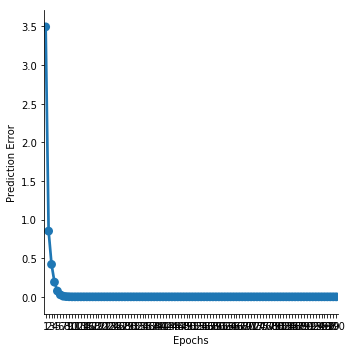

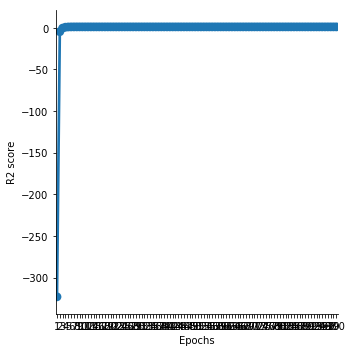

In [22]:
toy_data()

In [9]:
def encode_data(X_train,X_validation,bottleneck_layer_index,act_func,layers,learning_rate,epochs):
    
    X_train = feature_scaling(X_train)

    nl_obj = Neural_Network(layer_sizes = layers, activation_function = act_func,mode = "training",bottleneck_layer_index = bottleneck_layer_index)

    nl_obj.fit(X_train,X_train,epochs,learning_rate)

    C_X_train = nl_obj.network_layer[bottleneck_layer_index - 1].activations
    
    print(C_X_train.shape)
    
    
    C_X_validation = nl_obj.encoder(X_validation)
    
    print(C_X_validation.shape)
    
    # xx_validation = copy.deepcopy(X_validation)
    X_train_predicted = nl_obj.predict(X_train)
    X_validation_predicted = nl_obj.predict(X_validation)
    # print(X_train_predicted)

#     print(X_train[0,:])
#     print(X_train_predicted[0,:])


#     print(np.corrcoef(X_train,X_train_predicted))
    
#     print("performance: ",np.sum(X_train - X_train_predicted))

#     print("R2 train data: ",metrics.r2_score(X_train.T,X_train_predicted.T))
#     print("R2 validation data: ",metrics.r2_score(X_validation.T,X_validation_predicted.T))


#     error_vs_layer_df = pd.DataFrame(
#     {'Train Data Error': nl_obj.error_per_epoch,
#      'Epochs': nl_obj.epochs
#     })


#     error_vs_layer_df = error_vs_layer_df.melt('Epochs',value_name='Prediction Error')
#     error_vs_layer_graph = sns.factorplot(x="Epochs", y="Prediction Error", data=error_vs_layer_df)

#     error_vs_layer_df = pd.DataFrame(
#     {
#      'R2 score': nl_obj.r2,
#      'Epochs': nl_obj.epochs
#     })


#     error_vs_layer_df = error_vs_layer_df.melt('Epochs' , value_name='R2 score')
#     error_vs_layer_graph = sns.factorplot(x="Epochs", y="R2 score", data=error_vs_layer_df)

    return C_X_train, C_X_validation

In [42]:
X_train, X_validation, Y_train, Y_validation = data_preprocessing()

bottleneck_layer_neurons = 17

bottleneck_layer_index = 1
learning_rate = 0.01
epochs = 1000
act_func = ["linear","linear"]
layers = [X_train.shape[1],17,X_train.shape[1]]

C_X_train, C_X_validation = encode_data(X_train,X_validation,bottleneck_layer_index,act_func,layers,learning_rate,epochs)

(17498, 17)
0 1
here
(7500, 17)


In [43]:
X_train, X_validation, Y_train, Y_validation = data_preprocessing()
bottleneck_layer_neurons = 17

bottleneck_layer_index = 2
learning_rate = 0.001
epochs = 1000
act_func = ["linear","relu","relu","linear"]
layers = [X_train.shape[1],25,bottleneck_layer_neurons,25,X_train.shape[1]]

C_X_train, C_X_validation = encode_data(X_train,X_validation,bottleneck_layer_index,act_func,layers,learning_rate,epochs)

(17498, 17)
0 2
1 2
here
(7500, 17)


# K Means Clustering Algorithm Implementation

In [10]:
class K_Means():

    def __init__(self, k = 5, error_tolerance = 0.0000000001, max_iterations = 100):
        self.k = k
        self.error_tolerance = error_tolerance
        self.max_iterations = max_iterations
        
    def euclidean_distance(self,data_row, centroid, axis = 1):
        return np.linalg.norm(data_row - centroid, axis = axis)
    
    def initialize_centroids(self,data):
        self.centroids = []
        
        for index in range(self.k):
            data_index = random.randint(0,data.shape[0])
            self.centroids.append(data[data_index,:])
            
        self.centroids = np.asarray(self.centroids) 

    def find_centroid_label(self,X_data,y):
        
        centroid_label_dict = {}
        
        self.cluster_purity = {}
        
        data_index = 0
        
        for row in X_data:
            
            distances = self.euclidean_distance(row,self.centroids)
            closest_cluster_index = np.argmin(distances)
            if closest_cluster_index not in centroid_label_dict:
                centroid_label_dict[closest_cluster_index] = []
            centroid_label_dict[closest_cluster_index].append(y[data_index])
        
            data_index += 1
        
        for key,values in centroid_label_dict.items():
            
            value,counts = np.unique(np.asarray(values), return_counts = True)
            centroid_label_occurence = -np.sort(-counts)[0]
            self.cluster_purity[key] = centroid_label_occurence/np.sum(counts)
            
            centroid_label_dict[key] = copy.deepcopy(max(set(values),key=values.count))
        
        return centroid_label_dict
        
    def fit(self,X_data,y):
        self.initialize_centroids(X_data)
        
        cluster = np.zeros(X_data.shape[0])
        
        old_centriod = np.zeros(self.centroids.shape)
        
        error = self.euclidean_distance(self.centroids, old_centriod, None)
        
        inter = 0
        while inter<self.max_iterations or error > self.error_tolerance:
            inter += 1
            
            index = 0
            for row in X_data:
                distances = self.euclidean_distance(row,self.centroids)
                
    
                closest_cluster_index = np.argmin(distances)
                cluster[index] = closest_cluster_index
                index += 1
        
  
            old_centriod = copy.deepcopy(self.centroids)

            for i in range(self.k):
          
                data_points = [X_data[j] for j in range(len(X_data)) if cluster[j] == i]
                if data_points:
         
                    self.centroids[i] = copy.deepcopy(np.mean(data_points, axis=0))
                del data_points
            
            error = self.euclidean_distance(old_centriod, self.centroids,1)
            error = np.sum(error)
            
        self.centroid_label_dict = self.find_centroid_label(X_data,y)
    
    def predict(self,X_data):
        
        y_predicted = np.zeros(X_data.shape[0])
        
        index = 0
        for row in X_data:

            distances = self.euclidean_distance(row,self.centroids)

            closest_cluster_index = np.argmin(distances)
            y_predicted[index] = self.centroid_label_dict[closest_cluster_index]
            index += 1
        
        return y_predicted

## Confusion Matrix Generation

In [11]:
def generate_confusion_matrix(y_actual,y_predicted):
    
    confusion_matrix = metrics.cluster.contingency_matrix(y_actual, y_predicted)
    
    return confusion_matrix 

## Accuracy Computation

In [12]:
def calculate_accuracy(y_actual,y_predicted):
    
    confusion_matrix = generate_confusion_matrix(y_actual,y_predicted)
    
    return np.sum(np.amax(confusion_matrix, axis=0))/np.sum(confusion_matrix)

## Train and Evaluate K Means Model

In [13]:
def kmeans_train_evaluate(X_train, X_validation, y_train, y_validation,bottleneck_layer_index,act_func,layers,bottleneck_layer_neurons,no_of_clusters,learning_rate,epochs):
    
    
    X, X_validation = encode_data(X_train,X_validation,bottleneck_layer_index,act_func,layers,learning_rate,epochs)
    
    X = feature_scaling(X)
    
    X_validation = scale_test_data(X_validation)
    
    print("Custom Implementation of K Means Clustering")
    
    kmeans = K_Means(k = no_of_clusters)
    kmeans.fit(X,y_train)

    print()
    for key,values in kmeans.cluster_purity.items():
        print("Purity of cluster",key, " is: ", values)
    print()
    
    print("Performance on train data")
    y_predicted = kmeans.predict(X)
    print(np.unique(y_train.T),np.unique(y_predicted))
    print("Accuracy: ",calculate_accuracy(y_train,y_predicted))
    print()
    
    print("Clustering based on first two principal component using custom implementation")
    
    plt.figure(figsize=(10, 20))
    plt.subplot(2, 1, 1)
    
    plt.title('K Means clustering on training data based on Custom implementation')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    
    plt.scatter(X[:, 0], X[:, 1], c=y_predicted, s=40, cmap='viridis');
    print("Performance on validation data")
    y_predicted = kmeans.predict(X_validation)
    print("Accuracy: ",calculate_accuracy(y_validation,y_predicted))
    
    print()
    
    print("Scikit Learn Library Implementation of K Means Clustering")

    plt.subplot(2, 1, 2)
    
    k_means = KMeans(n_clusters=5, random_state=0)
    
    k_means.fit(X)
        
    print("Performance on train data")
    y_pred_train = k_means.predict(X)
    print("Accuracy: ",calculate_accuracy(y_train,y_pred_train))
    print()
    print("Clustering based on first two principal component using Scikit Learn")
    
    plt.title('K Means clustering on training data based on Scikit Learn library')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    
    plt.scatter(X[:, 0], X[:, 1], c=y_pred_train, s=40, cmap='viridis');
    
    print("Performance on validation data")
    y_pred_validation = k_means.predict(X_validation)
    print("Accuracy: ",calculate_accuracy(y_validation,y_pred_validation))

## Hierarchical Clustering

In [14]:
def hierarchial_clustering(X_train, X_validation, y_train, y_validation,linkage_type,bottleneck_layer_index,act_func,layers,bottleneck_layer_neurons,no_of_clusters,learning_rate,epochs):
    
    X, X_validation = encode_data(X_train,X_validation,bottleneck_layer_index,act_func,layers,learning_rate,epochs)
    
    X = feature_scaling(X)
    
    X_validation = scale_test_data(X_validation)
    
    Y = pdist(X)
    Z = hierarchy.linkage(Y, method = linkage_type, metric = "euclidean")
    T = hierarchy.fcluster(Z, no_of_clusters, criterion = "maxclust")
    
    lens = {}      
    centroids = {} 
    for idx,clno in enumerate(T):
        centroids.setdefault(clno,np.zeros(bottleneck_layer_neurons)) 
        centroids[clno] += X[idx,:]
        lens.setdefault(clno,0)
        lens[clno] += 1
    
    for clno in centroids:
        centroids[clno] /= float(lens[clno])
        
    centroid_positions = []

    
    for key ,values in centroids.items():
        centroid_positions.append(values.tolist())
    
    centroid_positions = np.asarray(centroid_positions)
    
    centroids_labels_dicts = {}
    
    index = 0
    for row in X:
        
        distances = np.linalg.norm(row - centroid_positions, axis = 1)
        
        closest_cluster_index = np.argmin(distances)
        
        if closest_cluster_index not in centroids_labels_dicts:
            centroids_labels_dicts[closest_cluster_index] = []

        centroids_labels_dicts[closest_cluster_index].append(y_train[index])
        
        index += 1
        
    
    print()
    for key,values in centroids_labels_dicts.items():
    
        value,counts = np.unique(np.asarray(values), return_counts = True)

        centroid_label_occurence = -np.sort(-counts)[0]
        purity = centroid_label_occurence/np.sum(counts)
        
        print("Purity of cluster",key, " is: ", purity)
        
    print()
    
    Z = linkage(X, linkage_type)

    plt.figure(figsize=(10, 20))
    plt.subplot(3, 1, 1)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Cluster Size')
    plt.ylabel('Distance')
    dendrogram(
        Z,
        truncate_mode='lastp', 
        p=no_of_clusters,  
        show_leaf_counts=True,
        leaf_rotation=90.,
        leaf_font_size=12.,
        show_contracted=True,
    )
    
    
    clustering_model = AgglomerativeClustering(affinity='euclidean',linkage=linkage_type,n_clusters=no_of_clusters)
    clustering_model.fit(X)
    
    plt.subplot(3, 1, 2)  
    plt.title('Hierarchical clustering on training data')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.scatter(X[:,0], X[:,1], c=clustering_model.labels_, cmap='viridis')  

    y_train_predicted = clustering_model.fit_predict(X)
    y_validation_predicted = clustering_model.fit_predict(X_validation)

    plt.subplot(3, 1, 3)
    plt.title('Hierarchical clustering on validation data')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.scatter(X_validation[:,0], X_validation[:,1], c=y_validation_predicted, cmap='viridis')
    
    plt.show()

    print("Accuracy on train data: ",calculate_accuracy(y_train_predicted,y_train))

    print("Accuracy on validation data: ",calculate_accuracy(y_validation_predicted,y_validation))

In [15]:
def train_evaluation_hierarical_model(X_train, X_validation, y_train, y_validation,linkage_type,bottleneck_layer_index,act_func,layers,bottleneck_layer_neurons,no_of_clusters,learning_rate,epochs):
    
    print()
    print("Using linkage type ",linkage_type)
    hierarchial_clustering(X_train, X_validation, y_train, y_validation,linkage_type,bottleneck_layer_index,act_func,layers,bottleneck_layer_neurons,no_of_clusters,learning_rate,epochs)

    print()

In [16]:
def visualize_pie_chart(X_train, X_validation, y_train, y_validation,linkage_type,bottleneck_layer_index,act_func,layers,bottleneck_layer_neurons,no_of_clusters,learning_rate,epochs):
    
    X, X_validation = encode_data(X_train,X_validation,bottleneck_layer_index,act_func,layers,learning_rate,epochs)
    
    X = feature_scaling(X)
    
    X_validation = scale_test_data(X_validation)
    
    linkage_list = ['ward','single','average','complete']
    
    train_accuracy_list = []
    validation_accuracy_list = []
    
    for linkage_type in linkage_list:
    
        clustering_model = AgglomerativeClustering(affinity='euclidean',linkage=linkage_type,n_clusters=no_of_clusters)
        clustering_model.fit(X)

        y_train_predicted = clustering_model.fit_predict(X)
        y_validation_predicted = clustering_model.fit_predict(X_validation)
        
        train_accuracy_list.append(calculate_accuracy(y_train_predicted,y_train))
        validation_accuracy_list.append(calculate_accuracy(y_validation_predicted,y_validation))
        
    
    train_df = pd.DataFrame({
        
        "Linkage_Type":linkage_list,
        "Accuracy":train_accuracy_list
    })
    
    validation_df = pd.DataFrame({
        
        "Linkage_Type":linkage_list,
        "Accuracy":validation_accuracy_list
    })
    
    print(train_df)
    print(validation_df)
    
    train_accuracy = train_df.Accuracy.groupby(train_df.Linkage_Type).sum()
    plt.axis('equal');
    plt.pie(train_accuracy, labels=train_accuracy.index);
    plt.show()
    
    validation_accuracy = validation_df.Accuracy.groupby(validation_df.Linkage_Type).sum()
    plt.axis('equal');
    plt.pie(validation_accuracy, labels=validation_accuracy.index);
    plt.show()

# Gaussian Mixture Model 

In [17]:
def gausian_mixture_model(X_train, X_validation, y_train, y_validation,bottleneck_layer_index,act_func,layers,bottleneck_layer_neurons,no_of_clusters,learning_rate,epochs):

    X, X_validation = encode_data(X_train,X_validation,bottleneck_layer_index,act_func,layers,learning_rate,epochs)
    
    X = feature_scaling(X)
    
    X_validation = scale_test_data(X_validation)
    
    gmm = GaussianMixture(n_components=no_of_clusters).fit(X)
    y_train_predicted = gmm.predict(X)
    
    
    centroids_labels_dicts = {}
    
    index = 0
    for row in X:
        
        distances = np.linalg.norm(row - gmm.means_, axis = 1)
        
        closest_cluster_index = np.argmin(distances)
        
        if closest_cluster_index not in centroids_labels_dicts:
            centroids_labels_dicts[closest_cluster_index] = []
                
        centroids_labels_dicts[closest_cluster_index].append(y_train[index])
        
        index += 1
        
    
    print()
    for key,values in centroids_labels_dicts.items():
    
        value,counts = np.unique(np.asarray(values), return_counts = True)
        centroid_label_occurence = -np.sort(-counts)[0]
        purity = centroid_label_occurence/np.sum(counts)
        
        print("Purity of cluster",key, " is: ", purity)
        print()
    print()
    
    plt.figure(figsize=(10, 20))
    plt.subplot(2, 1, 1)
    
    plt.title('GMM clustering on train data')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.scatter(X[:,0], X[:,1], c = y_train_predicted, s=40, cmap='viridis')
     
    y_validation_predicted = gmm.predict(X_validation)
    
    print()
    print()
    
    plt.subplot(2, 1, 2)
    
    plt.title('GMM clustering on train data')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.scatter(X_validation[:,0], X_validation[:,1], c = y_validation_predicted, s=40, cmap='viridis')
        
    print("Accuracy on train dataset: ",calculate_accuracy(y_train, y_train_predicted))
    print("Accuracy on validation dataset: ",calculate_accuracy(y_validation, y_validation_predicted))

## K Means Clustering Using 3 Layer AutoEncoder

(17498, 17)
0 1
here
(7500, 17)
Custom Implementation of K Means Clustering


/usr/lib/python3/dist-packages/ipykernel_launcher.py:251: RuntimeWarning:

overflow encountered in exp




Purity of cluster 2  is:  0.9248721227621484
Purity of cluster 4  is:  0.9911949685534591
Purity of cluster 1  is:  0.6302469135802469
Purity of cluster 0  is:  0.45141215892771663
Purity of cluster 3  is:  0.7824828085414405

Performance on train data
[0. 1. 2. 3. 4.] [0. 1.]
Accuracy:  0.83666704766259

Clustering based on first two principal component using custom implementation
Performance on validation data
Accuracy:  0.626

Scikit Learn Library Implementation of K Means Clustering
Performance on train data
Accuracy:  0.8370099439935993

Clustering based on first two principal component using Scikit Learn
Performance on validation data
Accuracy:  0.5905333333333334


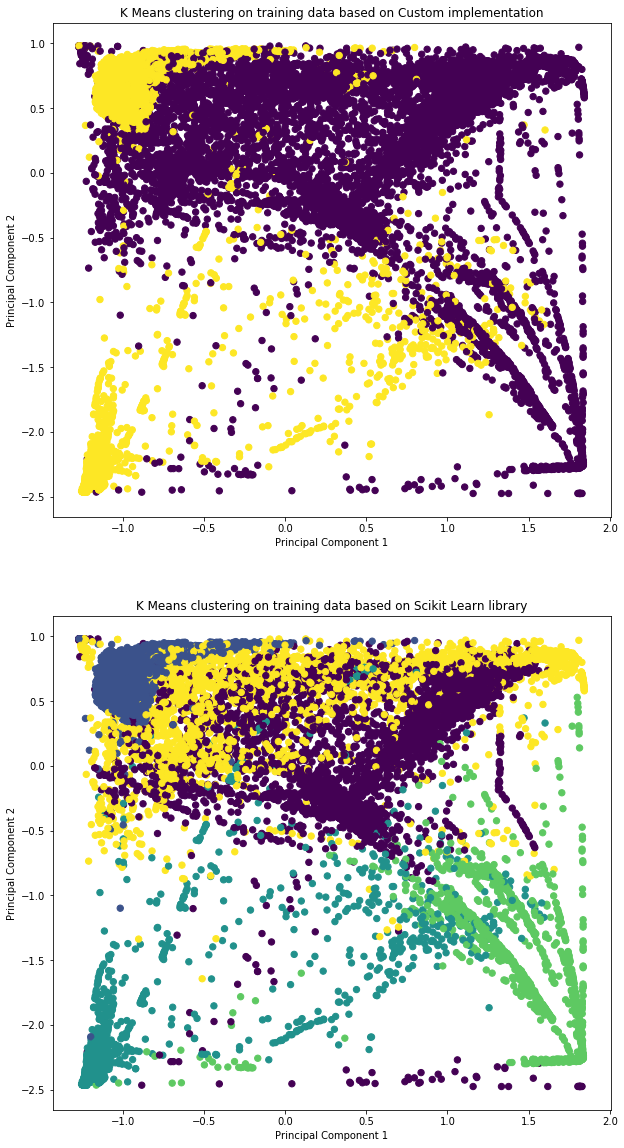

In [44]:
bottleneck_layer_neurons = 17
no_of_clusters = 5
bottleneck_layer_index = 1
learning_rate = 0.01
epochs = 1000
act_func = ["sigmoid","linear"]

X_train, X_validation, y_train, y_validation = data_preprocessing()
layers = [X_train.shape[1],bottleneck_layer_neurons,X_train.shape[1]]

kmeans_train_evaluate(X_train, X_validation, y_train, y_validation,bottleneck_layer_index,act_func,layers,bottleneck_layer_neurons,no_of_clusters,learning_rate,epochs)

## K Means Clustering Using Deep AutoEncoder

(17498, 17)
0 2
1 2
here
(7500, 17)


/usr/lib/python3/dist-packages/ipykernel_launcher.py:251: RuntimeWarning:

overflow encountered in exp



Custom Implementation of K Means Clustering

Purity of cluster 2  is:  0.8928457531625386
Purity of cluster 3  is:  0.9688073394495413
Purity of cluster 4  is:  0.9828125
Purity of cluster 1  is:  0.49361465852304276
Purity of cluster 0  is:  0.6487972508591066

Performance on train data
[0. 1. 2. 3. 4.] [0. 1. 4.]
Accuracy:  0.8550120013715853

Clustering based on first two principal component using custom implementation
Performance on validation data
Accuracy:  0.6305333333333333

Scikit Learn Library Implementation of K Means Clustering
Performance on train data
Accuracy:  0.8585552634586809

Clustering based on first two principal component using Scikit Learn
Performance on validation data
Accuracy:  0.6344


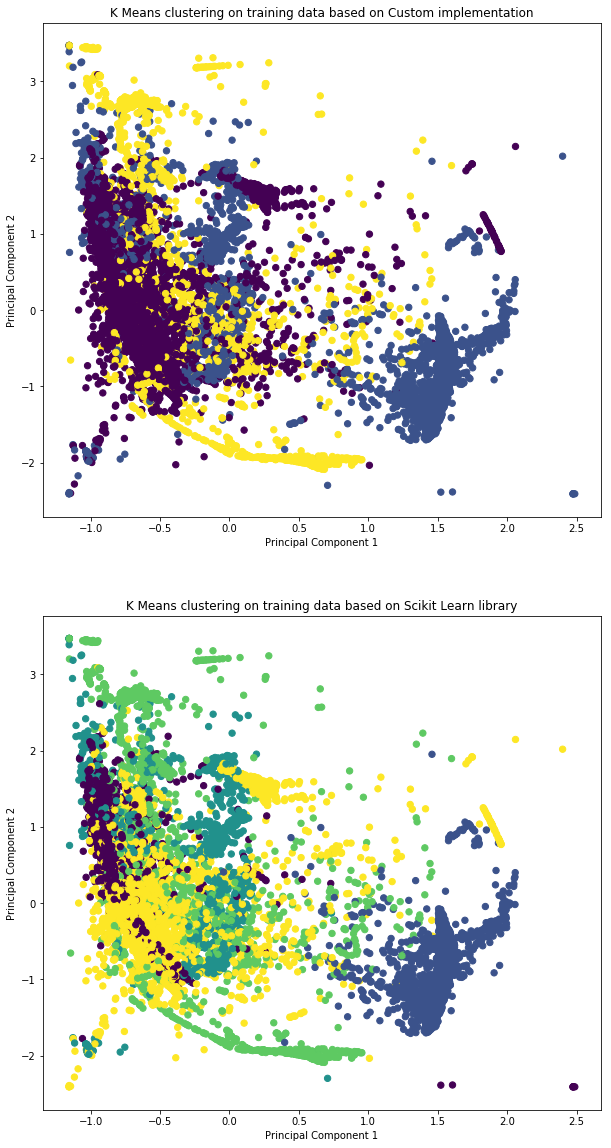

In [46]:
bottleneck_layer_neurons = 17
no_of_clusters = 5
bottleneck_layer_index = 2
learning_rate = 0.001
epochs = 1000
act_func = ["relu","sigmoid","relu","relu"]

X_train, X_validation, y_train, y_validation = data_preprocessing()
layers = [X_train.shape[1],25,bottleneck_layer_neurons,25,X_train.shape[1]]

kmeans_train_evaluate(X_train, X_validation, y_train, y_validation,bottleneck_layer_index,act_func,layers,bottleneck_layer_neurons,no_of_clusters,learning_rate,epochs)

## GMM Using 3 Layer AutoEncoder

(17498, 17)
0 1
here
(7500, 17)


/usr/lib/python3/dist-packages/ipykernel_launcher.py:251: RuntimeWarning:

overflow encountered in exp




Purity of cluster 1  is:  0.976410814734168

Purity of cluster 0  is:  0.9941077441077442

Purity of cluster 2  is:  0.44904761904761903

Purity of cluster 3  is:  0.47318611987381703

Purity of cluster 4  is:  0.8323538509124652




Accuracy on train dataset:  0.8120928106069265
Accuracy on validation dataset:  0.5298666666666667


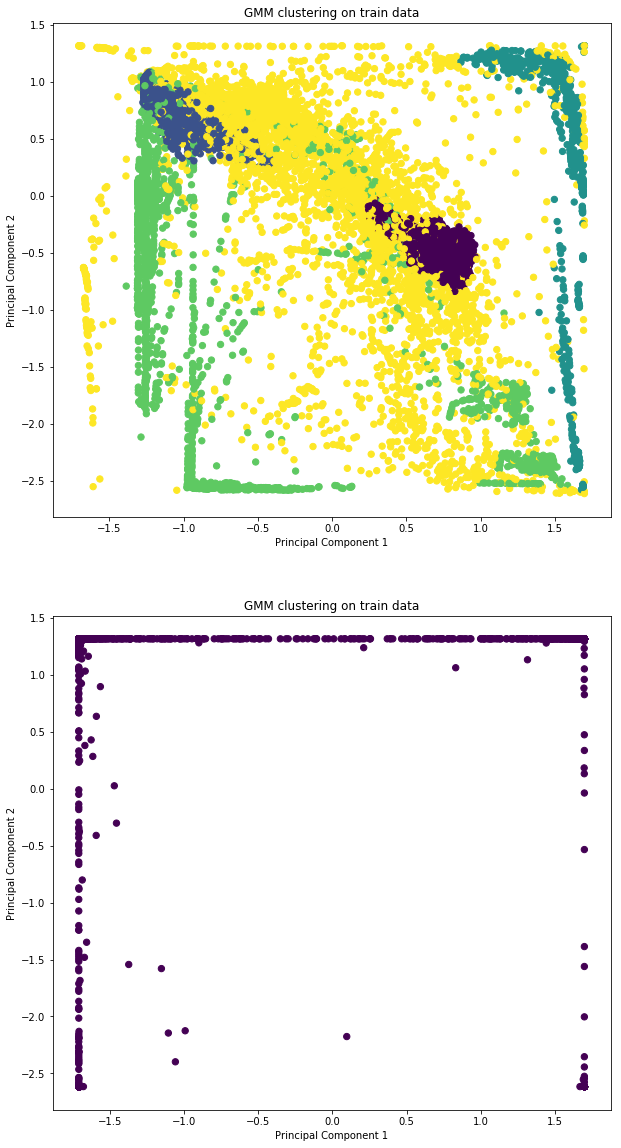

In [47]:
bottleneck_layer_neurons = 17
no_of_clusters = 5
bottleneck_layer_index = 1
learning_rate = 0.01
epochs = 1000
act_func = ["sigmoid","linear"]

X_train, X_validation, y_train, y_validation = data_preprocessing()

layers = [X_train.shape[1],bottleneck_layer_neurons,X_train.shape[1]]

gausian_mixture_model(X_train, X_validation, y_train, y_validation,bottleneck_layer_index,act_func,layers,bottleneck_layer_neurons,no_of_clusters,learning_rate,epochs)

## GMM Using Deep AutoEncoder

(17498, 25)
0 1
here
(7500, 25)


/usr/lib/python3/dist-packages/ipykernel_launcher.py:251: RuntimeWarning:

overflow encountered in exp




Purity of cluster 2  is:  0.8690488379236203

Purity of cluster 0  is:  0.9849843587069864

Purity of cluster 3  is:  0.45681381957773515

Purity of cluster 1  is:  0.6139315230224321

Purity of cluster 4  is:  0.8




Accuracy on train dataset:  0.8296948222654018
Accuracy on validation dataset:  0.5298666666666667


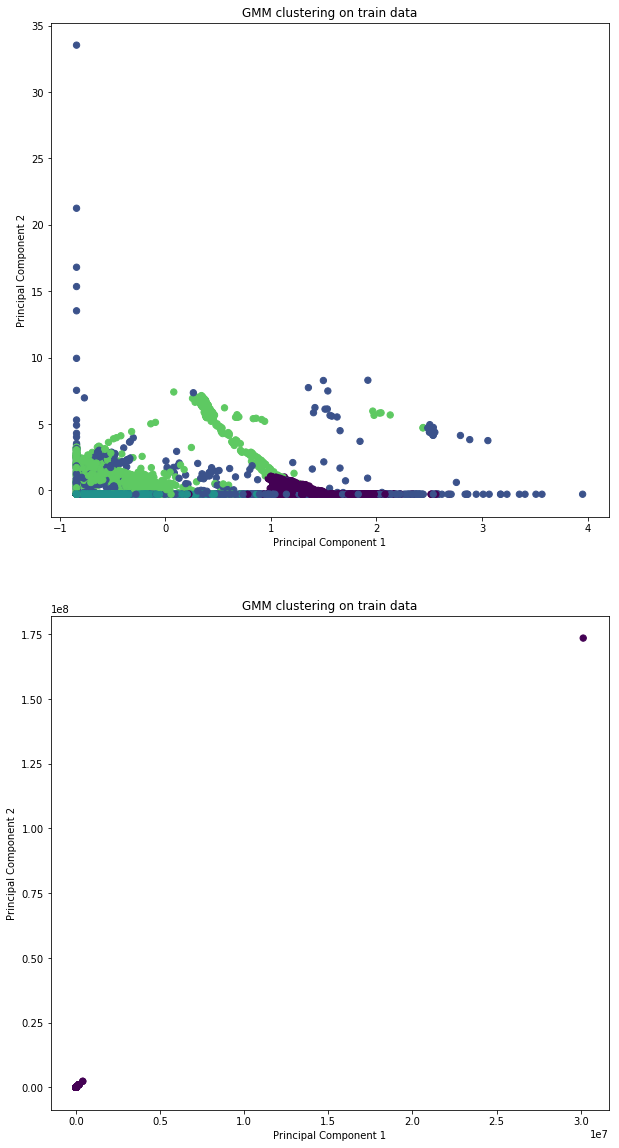

In [ ]:
bottleneck_layer_neurons = 17
no_of_clusters = 5
bottleneck_layer_index = 1
learning_rate = 0.001
epochs = 1000
act_func = ["relu","sigmoid","relu","relu"]

X_train, X_validation, y_train, y_validation = data_preprocessing()

layers = [X_train.shape[1],25,bottleneck_layer_neurons,25,X_train.shape[1]]

gausian_mixture_model(X_train, X_validation, y_train, y_validation,bottleneck_layer_index,act_func,layers,bottleneck_layer_neurons,no_of_clusters,learning_rate,epochs)

## Hierarchical Clustering Model Using 3 Layer AutoEncoder


Using linkage type  ward
(17498, 5)
0 1
here
(7500, 5)


/usr/lib/python3/dist-packages/ipykernel_launcher.py:251: RuntimeWarning:

overflow encountered in exp




Purity of cluster 0  is:  0.8972310969116081
Purity of cluster 1  is:  0.979705943259474
Purity of cluster 2  is:  0.8388072601555747
Purity of cluster 3  is:  0.4354765161878705
Purity of cluster 4  is:  0.7911089866156787



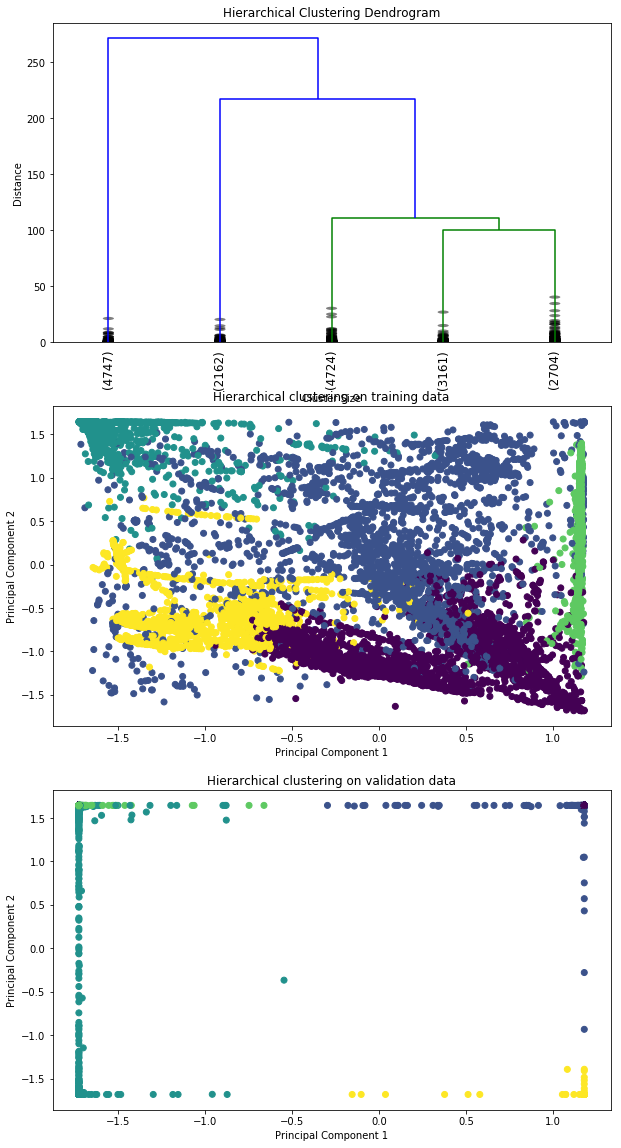

Accuracy on train data:  0.5454909132472282
Accuracy on validation data:  0.5764

(17498, 5)
0 1
here
(7500, 5)


/usr/lib/python3/dist-packages/ipykernel_launcher.py:251: RuntimeWarning:

overflow encountered in exp



  Linkage_Type  Accuracy
0         ward  0.757172
1       single  0.999257
2      average  0.803692
3     complete  0.641673
  Linkage_Type  Accuracy
0         ward  0.385733
1       single  0.996933
2      average  0.443867
3     complete  0.443333


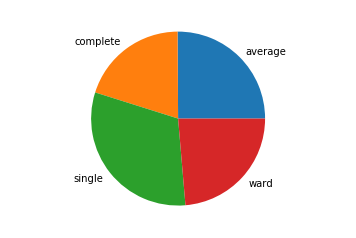

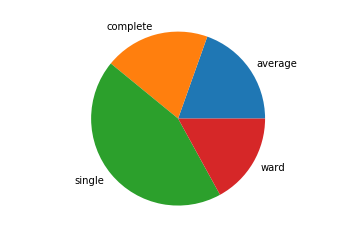

In [18]:
bottleneck_layer_neurons = 5
no_of_clusters = 5
bottleneck_layer_index = 1
learning_rate = 0.01
epochs = 1000
act_func = ["sigmoid","linear"]

X_train, X_validation, y_train, y_validation = data_preprocessing()

layers = [X_train.shape[1],bottleneck_layer_neurons,X_train.shape[1]]

linkage_type = "ward" #single, complete, average
train_evaluation_hierarical_model(X_train, X_validation, y_train, y_validation,linkage_type,bottleneck_layer_index,act_func,layers,bottleneck_layer_neurons,no_of_clusters,learning_rate,epochs)

visualize_pie_chart(X_train, X_validation, y_train, y_validation,linkage_type,bottleneck_layer_index,act_func,layers,bottleneck_layer_neurons,no_of_clusters,learning_rate,epochs)

## Hierarchical Clustering Model Using Deep AutoEncoder

(17498, 5)
0 2
1 2
here
(7500, 5)
  Linkage_Type  Accuracy
0         ward  0.834953
1       single  0.999371
2      average  0.999371
3     complete  0.999371
  Linkage_Type  Accuracy
0         ward  0.808667
1       single  0.996267
2      average  0.986533
3     complete  0.987467


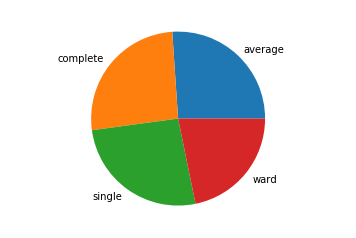

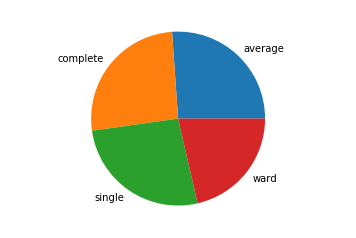

In [19]:
bottleneck_layer_neurons = 5
no_of_clusters = 5
bottleneck_layer_index = 2
learning_rate = 0.001
epochs = 1500
act_func = ["relu","relu","relu","relu"]

X_train, X_validation, y_train, y_validation = data_preprocessing()

layers = [X_train.shape[1],25,bottleneck_layer_neurons,25,X_train.shape[1]]

# linkage_type = "ward" #single, complete, average
# train_evaluation_hierarical_model(X_train, X_validation, y_train, y_validation,linkage_type,bottleneck_layer_index,act_func,layers,bottleneck_layer_neurons,no_of_clusters,learning_rate,epochs)

visualize_pie_chart(X_train, X_validation, y_train, y_validation,linkage_type,bottleneck_layer_index,act_func,layers,bottleneck_layer_neurons,no_of_clusters,learning_rate,epochs)